# Introduction

We'll validate our extraction of mental functions from article texts by comparing the term occurrences to manual annotations of articles in the BrainMap database.


# Load the data

In [1]:
import pandas as pd
import numpy as np

## BrainMap metadata 

In [2]:
df = pd.read_csv("../data/metadata.csv", encoding="latin-1")
df = df.loc[df["SOURCE"] == "BrainMap"]
len(df)

3346

In [3]:
pmids = df["PMID"].astype(int)
df["PMID"] = pmids

In [4]:
df.head(3)

,PMID,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,ABSTRACT_URL,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION
0,1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992.0,Sep,"Journal of Neurology, Neurosurgery, and Psychi...",Regional cerebral blood flow abnormalities in ...,768-773,55,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...
1,1410086,NaN,"Bench C J, 1992",BrainMap,Bench C J|Friston K J|Brown R G|Scott L C|Frac...,1992.0,Aug,Psychological Medicine,The anatomy of melancholia - focal abnormaliti...,607-615,22,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,10.0,"-13.68,29.54,33.76;-15.76,23.53,38.75;-39.5,38...",6030018.0,"['Action.Rest', 'Action.Rest', 'Action.Rest']","['Normals > Depressed', 'Unimpaired > Impaired...",Patients with depression and normal subjects u...
2,1448149,10.1038/360339a0,"Zatorre R J, 1992",BrainMap,Zatorre R J|Jones-Gotman M|Evans A C|Meyer E,1992.0,Nov,Nature,Functional localization and lateralization of ...,339-340,360,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,6.0,"-21.56,5.58,-27.71;22.3,6.36,-21.58;18.98,41.4...",8110311.0,['Perception.Olfaction'],['Odor vs. Odorless'],Subjects underwent 2 conditions in which they ...


## Document-term matrix

In [5]:
dtm = pd.read_csv("../data/text/dtm_190325.csv.gz", 
                  compression="gzip", index_col=0)
dtm = dtm.loc[pmids]
len(dtm)

3346

In [6]:
dtm.head(3)

,2_step,2step,3d_object,abductive_reasoning,aberrant_behavior,aberrant_behavior_checklist,ability,abstinence_syndrome,abstract_analogy,abstract_concrete_task,...,writing_task,yale_global_tic_severity,yale_global_tic_severity_scale,ybocs_total_score,young_mania_rating_scale,youth_drinking,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
1402966,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dtm.max()[:5]

2_step                  2
2step                   5
3d_object              25
abductive_reasoning     0
aberrant_behavior       1
dtype: int64

# Load the BrainMap taxonomy

In [8]:
def process_annotations(annotations):
    annotations = annotations.replace("[", "").replace("]", "")
    annotations = annotations.replace("'", "").replace(" ", "").split(",")
    annotations = [a for a in annotations if "." in a]
    return annotations

## Behavioral subdomains

In [9]:
subdomains = []
for i, row in df.iterrows():
    subdomains += process_annotations(row["BEHAVIORAL_DOMAIN"])     
subdomains = sorted(list(set(subdomains)))
subdomains[:5]

['Action.Execution',
 'Action.Execution.Speech',
 'Action.Imagination',
 'Action.Inhibition',
 'Action.MotorLearning']

## Behavioral domains

In [10]:
domains = sorted(list(set([s.split(".")[0] for s in subdomains])))
domains

['Action',
 'Cognition',
 'Emotion',
 'Interoception',
 'Perception',
 'Pharmacology']

## Behavioral taxonomy

In [11]:
taxonomy = {domain: [s for s in subdomains if s.startswith(domain)] for domain in domains}
taxonomy

{'Action': ['Action.Execution',
  'Action.Execution.Speech',
  'Action.Imagination',
  'Action.Inhibition',
  'Action.MotorLearning',
  'Action.Observation',
  'Action.Preparation',
  'Action.Rest'],
 'Cognition': ['Cognition.Attention',
  'Cognition.Language',
  'Cognition.Language.Orthography',
  'Cognition.Language.Phonology',
  'Cognition.Language.Semantics',
  'Cognition.Language.Speech',
  'Cognition.Language.Syntax',
  'Cognition.Memory',
  'Cognition.Memory.Explicit',
  'Cognition.Memory.Implicit',
  'Cognition.Memory.Working',
  'Cognition.Music',
  'Cognition.Reasoning',
  'Cognition.SocialCognition',
  'Cognition.Somatic',
  'Cognition.Spatial',
  'Cognition.Temporal'],
 'Emotion': ['Emotion.Intensity',
  'Emotion.Negative',
  'Emotion.Negative.Anger',
  'Emotion.Negative.Anxiety',
  'Emotion.Negative.Disgust',
  'Emotion.Negative.Embarrassment',
  'Emotion.Negative.Fear',
  'Emotion.Negative.Guilt',
  'Emotion.Negative.Punishment/Loss',
  'Emotion.Negative.Sadness',
  'Emot

## Subdomain titles

In [12]:
import re

In [13]:
subdomain2title = {}
for subdomain in subdomains:
    
    title = subdomain.split("(")[0]
    title = " (".join(title.split(".")[1:])
    
    if "(" in title:
        title += ")"
    
    words = re.findall("[A-Z][a-z)]*", subdomain)
    for word in words:
        title = title.replace(word, " " + word)
    
    if title.count("(") > 1:
        title = title[::-1].replace(" (", "/", title.count("(")-1)[::-1]
    
    title = re.sub(" +", " ", title)
    title = title.replace("( ", "(").replace(" -", "-").replace("- ", "-").replace(r" /", "/").replace(r"/ ", "/").strip()
    title = title.replace("Steroidsand", "Steroids and")
    
    subdomain2title[subdomain] = title

subdomain2title

{'Action.Execution': 'Execution',
 'Action.Execution.Speech': 'Execution (Speech)',
 'Action.Imagination': 'Imagination',
 'Action.Inhibition': 'Inhibition',
 'Action.MotorLearning': 'Motor Learning',
 'Action.Observation': 'Observation',
 'Action.Preparation': 'Preparation',
 'Action.Rest': 'Rest',
 'Cognition.Attention': 'Attention',
 'Cognition.Language': 'Language',
 'Cognition.Language.Orthography': 'Language (Orthography)',
 'Cognition.Language.Phonology': 'Language (Phonology)',
 'Cognition.Language.Semantics': 'Language (Semantics)',
 'Cognition.Language.Speech': 'Language (Speech)',
 'Cognition.Language.Syntax': 'Language (Syntax)',
 'Cognition.Memory': 'Memory',
 'Cognition.Memory.Explicit': 'Memory (Explicit)',
 'Cognition.Memory.Implicit': 'Memory (Implicit)',
 'Cognition.Memory.Working': 'Memory (Working)',
 'Cognition.Music': 'Music',
 'Cognition.Reasoning': 'Reasoning',
 'Cognition.SocialCognition': 'Social Cognition',
 'Cognition.Somatic': 'Somatic',
 'Cognition.Spatial

# Load the BrainMap annotations

In [14]:
dam = pd.DataFrame(0, index=pmids, columns=subdomains)
for pmid in pmids:
    annotations = process_annotations(df.loc[df["PMID"] == pmid, "BEHAVIORAL_DOMAIN"].values[0])
    for subdomain in annotations:
        dam.loc[pmid, subdomain] = dam.loc[pmid, subdomain] + 1
dam.head()

,Action.Execution,Action.Execution.Speech,Action.Imagination,Action.Inhibition,Action.MotorLearning,Action.Observation,Action.Preparation,Action.Rest,Cognition.Attention,Cognition.Language,...,Pharmacology.Caffeine,Pharmacology.Capsaicin,Pharmacology.Cocaine,Pharmacology.Marijuana,Pharmacology.Nicotine,Pharmacology.Non-SteroidalAnti-InflammatoryDrugs,Pharmacology.Opioids,Pharmacology.PsychiatricMedications,Pharmacology.PsychiatricMedications.Antidepressants,Pharmacology.SteroidsandHormones.Estrogen
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
dam.sum().sort_values()

Pharmacology.PsychiatricMedications.Antidepressants       1
Pharmacology.SteroidsandHormones.Estrogen                 2
Interoception.Thermoregulation                            3
Pharmacology.Caffeine                                     3
Pharmacology.Cocaine                                      4
Interoception.HeartbeatDetection                          4
Pharmacology.Capsaicin                                    9
Emotion.Negative.Punishment/Loss                         10
Pharmacology.PsychiatricMedications                      12
Pharmacology.Opioids                                     14
Interoception.Osmoregulation                             14
Emotion.Negative.Embarrassment                           19
Pharmacology.Amphetamines.Methamphetamine                22
Interoception.Thirst                                     22
Cognition.Memory.Implicit                                22
Pharmacology.Non-SteroidalAnti-InflammatoryDrugs         24
Interoception.Baroregulation            

# Reweight by TF-IDF

In [16]:
def tfidf(df):
    
    # Rows are documents, columns are terms
    # Inverse document frequencies
    doccount = float(df.shape[0])
    freqs = df.astype(bool).sum(axis=0)
    idfs = np.log(doccount / freqs)
    idfs[np.isinf(idfs)] = 0.0  # log(0) = 0
    
    # Term frequencies
    terms_in_doc = df.sum(axis=1)
    tfs = (df.T / terms_in_doc).T
    
    # TF-IDF reweighting
    X = tfs * idfs
    
    # Fill NA with 0
    X = X.fillna(0.0)
    
    return X

In [17]:
dtm_tfidf = tfidf(dtm)
dam_tfidf = tfidf(dam)

In [18]:
dtm_tfidf.head(3)

,2_step,2step,3d_object,abductive_reasoning,aberrant_behavior,aberrant_behavior_checklist,ability,abstinence_syndrome,abstract_analogy,abstract_concrete_task,...,writing_task,yale_global_tic_severity,yale_global_tic_severity_scale,ybocs_total_score,young_mania_rating_scale,youth_drinking,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
1402966,0.0,0.0,0.0,0.0,0.0,0.0,0.002921,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410086,0.0,0.0,0.0,0.0,0.0,0.0,0.002322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1448149,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Associate terms with domains

In [19]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

## Drop terms that never occurred

In [20]:
dtm_tfidf = dtm_tfidf.loc[:, (dtm_tfidf != 0).any(axis=0)]
dtm_tfidf.shape

(3346, 3172)

## Load associations and FDRs

In [21]:
import os

In [22]:
r_file = "data/domains_terms_r.csv"
p_file = "data/domains_terms_p.csv"
fdr_file = "data/domains_terms_fdr.csv"

if not os.path.exists(r_file) or not os.path.exists(p_file) or not os.path.exists(fdr_file):
    terms = list(dtm_tfidf.columns)
    r = pd.DataFrame(index=terms, columns=subdomains)
    p = pd.DataFrame(index=terms, columns=subdomains)
    fdr = pd.DataFrame(index=terms, columns=subdomains)

    for subdomain in subdomains:
        print("Processing {}".format(subdomain))
        for term in terms:
            rtest = pearsonr(dtm_tfidf[term], dam_tfidf[subdomain])
            r.loc[term, subdomain] = rtest[0]
            p.loc[term, subdomain] = rtest[1]
        fdr[subdomain] = multipletests(p[subdomain], method="fdr_bh")[1]

    r.to_csv(r_file)
    p.to_csv(p_file)
    fdr.to_csv(fdr_file)
    
else:
    r = pd.read_csv(r_file, index_col=0)
    p = pd.read_csv(p_file, index_col=0)
    fdr = pd.read_csv(fdr_file, index_col=0)

In [23]:
r["Action.Execution"].sort_values(ascending=False)[:10]

movement          0.608254
motor             0.575089
sensorimotor      0.484687
motor_control     0.317032
hand              0.310318
execution         0.289838
arm               0.281449
finger_tapping    0.258947
swallowing        0.250867
coordination      0.238535
Name: Action.Execution, dtype: float64

In [24]:
r.to_csv("data/domains_terms_r.csv")
p.to_csv("data/domains_terms_p.csv")
fdr.to_csv("data/domains_terms_fdr.csv")

## Identify top terms

In [26]:
top_n = 3
top_r, top_p, top_fdr = {}, {}, {}
for subdomain in subdomains:
    top_r[subdomain] = r[subdomain].sort_values(ascending=False)[:top_n]
    top_p[subdomain] = p[subdomain].sort_values(ascending=True)[:top_n]
    top_fdr[subdomain] = fdr[subdomain].sort_values(ascending=True)[:top_n]
    
    for term, term_fdr in zip(top_fdr[subdomain].index, top_fdr[subdomain]):
        if term_fdr > 0.001:
            print("{:26s}: {:26s} (FDR = {:2.4f})".format(subdomain, term, term_fdr))

In [26]:
top_r["Action.Execution"]

movement        0.608254
motor           0.575089
sensorimotor    0.484687
Name: Action.Execution, dtype: float64

In [27]:
top_fdr["Action.Execution"]

movement         0.000000e+00
motor           9.726361e-291
sensorimotor    1.081846e-193
Name: Action.Execution, dtype: float64

In [ ]:
for 

## Compute bootstrap distributions

In [28]:
np.random.seed(42)

In [29]:
n_iter = 5000
n_articles = len(dtm_tfidf)
top_boot = {}
for subdomain in subdomains:
    print("Processing {}".format(subdomain))
    terms = top_r[subdomain].index
    top_boot[subdomain] = {term: np.empty(n_iter) for term in terms}
    for i in range(n_iter):
        boot = np.random.choice(range(n_articles), size=n_articles)
        for term in terms:
            r_boot = pearsonr(dtm_tfidf[term].values[boot], dam_tfidf[subdomain].values[boot])[0]
            top_boot[subdomain][term][i] = r_boot

Processing Action.Execution
Processing Action.Execution.Speech
Processing Action.Imagination
Processing Action.Inhibition
Processing Action.MotorLearning
Processing Action.Observation
Processing Action.Preparation


/anaconda3/envs/ontol/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Processing Action.Rest
Processing Cognition.Attention
Processing Cognition.Language
Processing Cognition.Language.Orthography
Processing Cognition.Language.Phonology
Processing Cognition.Language.Semantics
Processing Cognition.Language.Speech
Processing Cognition.Language.Syntax
Processing Cognition.Memory
Processing Cognition.Memory.Explicit
Processing Cognition.Memory.Implicit
Processing Cognition.Memory.Working
Processing Cognition.Music
Processing Cognition.Reasoning
Processing Cognition.SocialCognition
Processing Cognition.Somatic
Processing Cognition.Spatial
Processing Cognition.Temporal
Processing Emotion.Intensity
Processing Emotion.Negative
Processing Emotion.Negative.Anger
Processing Emotion.Negative.Anxiety
Processing Emotion.Negative.Disgust
Processing Emotion.Negative.Embarrassment
Processing Emotion.Negative.Fear
Processing Emotion.Negative.Guilt
Processing Emotion.Negative.Punishment/Loss
Processing Emotion.Negative.Sadness
Processing Emotion.Neutral
Processing Emotion.O

In [30]:
n_iter_filt = 1000
top_boot_filt = {}
for subdomain in subdomains:
    top_boot_filt[subdomain] = {}
    for term in top_r[subdomain].index:
        boot_filt = [x for x in list(top_boot[subdomain][term]) if not x != x][:n_iter_filt]
        top_boot_filt[subdomain][term] = boot_filt
        if len(boot_filt) < n_iter_filt:
            print("{}: {} has <{} iterations".format(subdomain, term, n_iter_filt))

## Plot violins of associations

In [31]:
import pandas as pd
import seaborn as sns
import ptitprince as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import ImageColor

In [32]:
# Hex color mappings
c = {"red": "#CE7D69", "orange": "#BA7E39", "yellow": "#CEBE6D", 
     "chartreuse": "#AEC87C", "green": "#77B58A", "blue": "#7597D0", 
     "magenta": "#B07EB6", "purple": "#7D74A3", "brown": "#846B43", "pink": "#CF7593"}

# RGB color mappings
c = {name: np.array(ImageColor.getrgb(color)) / 255.0 for name, color in c.items()}

# Palette for framework
domain2color = {"Action": c["red"], "Emotion": c["blue"], 
                "Cognition": c["green"], "Perception": c["purple"], 
                "Interoception": c["yellow"], "Pharmacology": c["orange"]}

# Default line width for plots
mpl.rcParams["axes.linewidth"] = 1.5

In [33]:
def plot_violins(domain, subdomains, names, r_data, fdr_data, boot_data, 
                 font="../style/Arial Unicode.ttf", title_font="../style/Arial Bold.ttf",
                 xlabel="Association of BrainMap annotations and extracted terms ($r$)",
                 path="", print_fig=True, color="gray"):

    i = 0
    top_n = len(boot_data[subdomains[0]].keys())
    n_iter = len(list(boot_data[subdomains[0]].values())[0])
    
    fig, axes = plt.subplots(nrows=len(subdomains), ncols=1) #figsize=(8, 0.5 + (1.65 * len(subdomains))))
    
    mpl.rcParams["axes.linewidth"] = 1.5
    
    font_prop_ax = mpl.font_manager.FontProperties(fname=font, size=11)
    font_prop_lab = mpl.font_manager.FontProperties(fname=font, size=12)
    font_prop_title = mpl.font_manager.FontProperties(fname=title_font, size=12, weight="bold")
    
    for i, subdomain, ax in zip(range(len(subdomains)), subdomains, axes.flatten()):
        
        terms = list(boot_data[subdomain].keys())
        subdomain_terms, subdomain_r = [], []
        
        for n_i in range(top_n):
            subdomain_terms += [terms[n_i]] * n_iter
            subdomain_r += list(boot_data[subdomain][terms[n_i]])
        df = pd.DataFrame({"term": subdomain_terms, "r": subdomain_r})
        
        for j, term in enumerate(terms):
            
            v = ax.violinplot(sorted(boot_data[subdomain][term]), positions=[j], vert=False, 
                              showmeans=False, showmedians=False, widths=0.8)
            
            for pc in v["bodies"]:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_linewidth(1.5)
                pc.set_alpha(0.25)
            
            for line in ["cmaxes", "cmins", "cbars"]:
                v[line].set_edgecolor("none")
                
            ax.scatter(r_data[subdomain][term], j, color="gray", s=25, zorder=2)
            
            term_size = r_data[subdomain][term] * 25
            ax.annotate(term.replace("_", " "), 
                        (max(boot_data[subdomain][term]) + 0.0125, j + 0.125), color=color, 
                        font_properties=mpl.font_manager.FontProperties(fname=font, size=term_size))

        for side in ["left", "right", "top"]:
            ax.spines[side].set_visible(False)
        
        if i < (len(subdomains) - 1):
            ax.set_xlabel("")
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.spines["bottom"].set_visible(False)
        
        ax.set_xlim([0, 1])
        ax.set_ylim([-0.35, top_n + 0.35])
        
        ax.invert_yaxis()
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel(names[i], fontproperties=font_prop_title, color=color, labelpad=12)
    
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1], fontproperties=font_prop_ax)
    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.set_xlabel(xlabel, fontproperties=font_prop_lab, labelpad=10)
    ax.spines["bottom"].set_visible(True)
    
    plt.tight_layout()
    
    file_name = "{}raincloud/{}.png".format(path, domain)
    plt.savefig(file_name, dpi=500, bbox_inches="tight")

    if print_fig:
        plt.show()
    plt.close()

In [58]:
def plot_barcharts(domain, subdomains, names, freqs, r_data, fdr_data, boot_data, ci=0.95,
                   font="../style/Arial Unicode.ttf", title_font="../style/Arial Unicode.ttf",
                   xlabel="Association of BrainMap annotations and extracted terms ($r$)",
                   path="", print_fig=True, color="gray"):

    i = 0
    top_n = len(boot_data[subdomains[0]].keys())
    n_iter = len(list(boot_data[subdomains[0]].values())[0])
    
    fig, axes = plt.subplots(nrows=len(subdomains), ncols=1, figsize=(5, len(subdomains)))
    plt.subplots_adjust(hspace=0)
    
    font_prop_ax = mpl.font_manager.FontProperties(fname=font, size=14)
    font_prop_lab = mpl.font_manager.FontProperties(fname=font, size=13.5)
    font_prop_title = mpl.font_manager.FontProperties(fname=title_font, size=15, weight="bold")
    
    for i, subdomain, ax in zip(range(len(subdomains)), subdomains, axes.flatten()):
        
        terms = list(boot_data[subdomain].keys())
        subdomain_terms, subdomain_r = [], []
        
        for n_i in range(top_n):
            subdomain_terms += [terms[n_i]] * n_iter
            subdomain_r += list(boot_data[subdomain][terms[n_i]])
        df = pd.DataFrame({"term": subdomain_terms, "r": subdomain_r})
        
        for j, term in enumerate(terms):
            
            ax.barh(j, r_data[subdomain][term], color=color, alpha=0.4, height=0.7)
            
            boot_term = sorted(boot_data[subdomain][term])
            n_iter = len(boot_term)
            ci_lower = boot_term[int((1.0 - ci) * n_iter)]
            ci_upper = boot_term[int(ci * n_iter)]
            ax.plot([ci_lower, ci_upper], [j, j], color="black", linewidth=1.5)
            ax.plot([ci_lower, ci_lower], [j - 0.2, j + 0.2], color="black", linewidth=1.5)
            ax.plot([ci_upper, ci_upper], [j - 0.2, j + 0.2], color="black", linewidth=1.5)
            
            ax.annotate(term.replace("_", " "), 
                        (ci_upper + 0.025, j + 0.125), color=color, font_properties=font_prop_lab)
            
        for side in ["right", "top"]:
            ax.spines[side].set_visible(False)
        
        ax.set_xlim([0, 1])
        ax.set_ylim([-0.35, top_n + 0.35])
        ax.invert_yaxis()
        ax.set_yticks([])
        ax.set_yticklabels([])
        
        num = format(int(freqs.values[i]), ",")
        name =  "{}\n$n$ = {}\n".format(names[i], num)
        ax.set_ylabel(name, fontproperties=font_prop_title, color=color, labelpad=10, 
                      rotation=0, ha="right", va="center")
        
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])
        ax.set_xticklabels([])
        ax.xaxis.set_tick_params(width=0, length=0)
        ax.spines["bottom"].set_visible(False)
    
    ax.spines["bottom"].set_visible(True)   
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1, ""], fontproperties=font_prop_ax)
    ax.xaxis.set_tick_params(width=1.25, length=7)
    ax.set_xlabel(xlabel, fontproperties=font_prop_lab, labelpad=10)
        
    file_name = "{}barchart/{}.png".format(path, domain)
    plt.savefig(file_name, dpi=500, bbox_inches="tight")

    if print_fig:
        plt.show()
    plt.close()

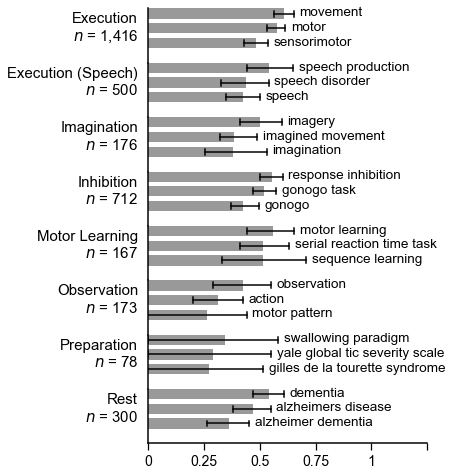

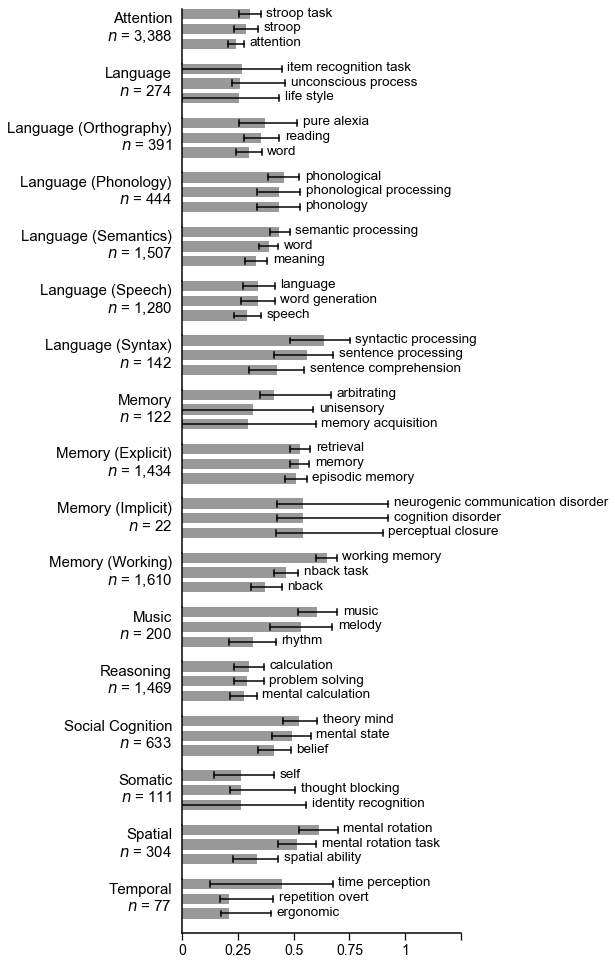

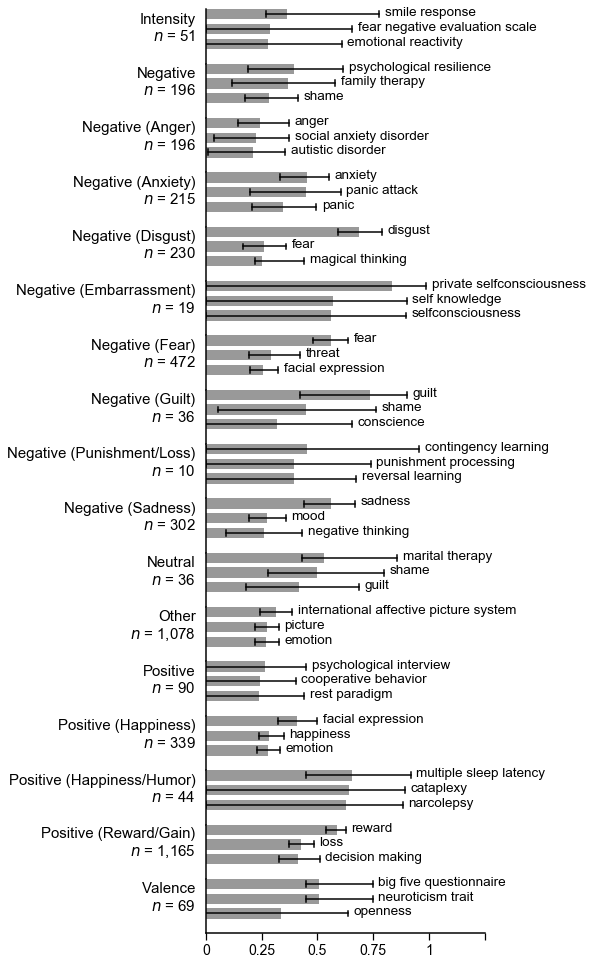

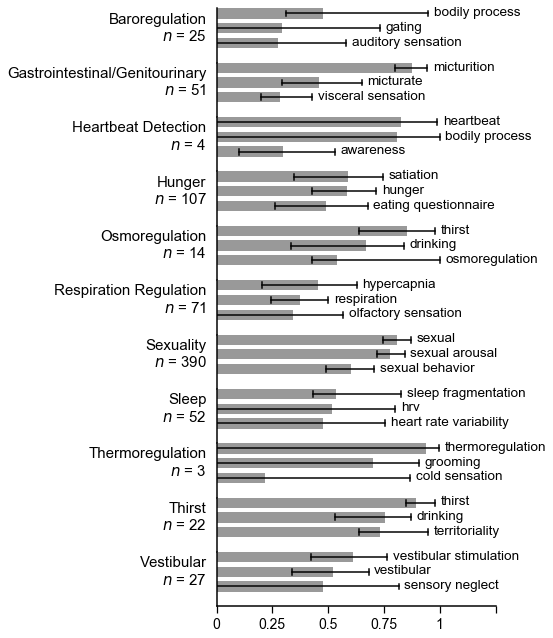

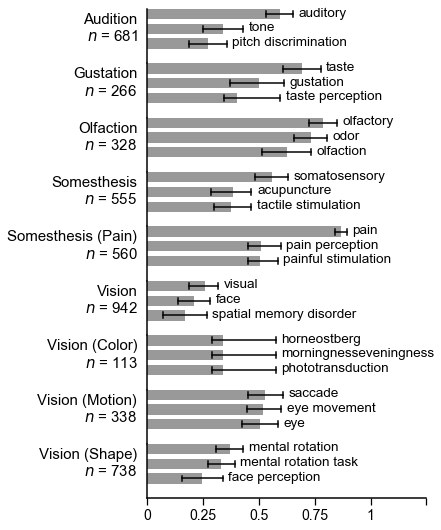

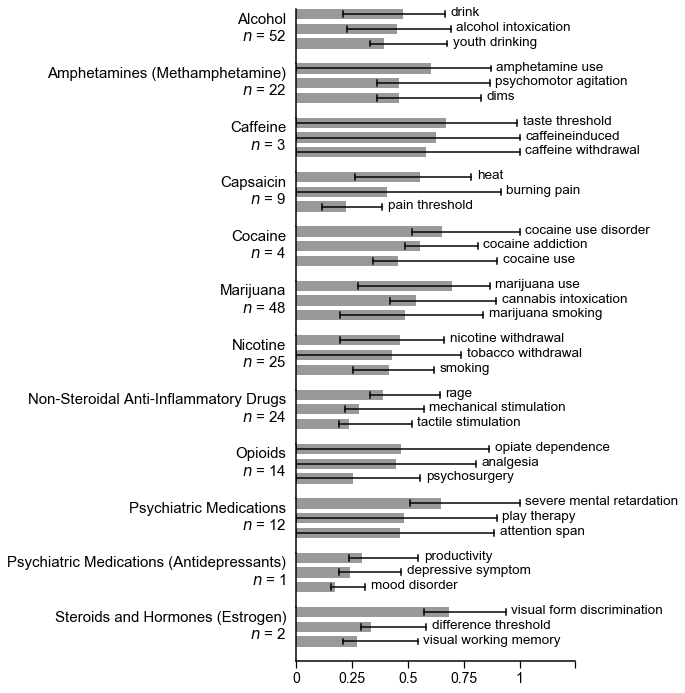

In [59]:
mpl.rcParams["axes.linewidth"] = 1.5

freqs = dam.sum()
for domain in domains:
    names = [subdomain2title[subdomain] for subdomain in taxonomy[domain]]
    freqs = dam.sum().loc[taxonomy[domain]]
    plot_barcharts(domain, taxonomy[domain], names, freqs, top_r, top_fdr, top_boot_filt, 
                   path="figures/brainmap/", color="black", xlabel="")